# ACM40960

### 1. Load relevant libraries

In [686]:
import pandas as pd
from pandas import DataFrame
import glob
import math
import numpy as np
import seaborn as sns
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import linear_model
import mord
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from scipy.stats import probplot
from scipy.stats import norm
from scipy.stats import boxcox
from scipy.special import boxcox as spboxcox
from scipy.special import inv_boxcox
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as lda
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from collections import Counter
import random

### 2. Load the data

Load the data from all csv files in the Data folder, and merge into a single data frame

In [471]:
# Define data files path name
path = 'Data/'

# Get file names of all csv files in the Data folder
filenames = sorted(glob.glob(path + "/*.csv"))

# create empty list to store data frames from each EPL season
li = []

# loop through all csv file names
for filename in filenames:
    # read in 'HomeTeam', 'AwayTeam', 'FTR' columns for current file, drop rows with NAs
    df = pd.read_csv(filename, usecols=['HomeTeam', 'AwayTeam', 'FTR']).dropna()
    # append dataframe from current EPL year to list
    li.append(df)

# combine all data frames in list into a single data frame
EPL_original = pd.concat(li, axis=0)

# create copy of the EPL data frame so we can keep the originally loaded data frame if needed later
EPL = EPL_original.copy()

# reset row indices
EPL.reset_index(drop=True, inplace=True)

### 3. Define miscellaneous functions

Define logit and logistic functions for transforming the data where appropriate

In [472]:
# logit transformation function
def logit_tf(p):
    return np.log(p / (1-p))

# logistic transformation function
def logistic_tf(x):
    return 1 / (1 + np.exp(-x))

### 4. Calculate known metrics from the data

Calculate total number of points earned by each team each in the current season, and results obtained for each team in each fixture of each season. 

Then add new columns to EPL data frame for both home and away teams, containing:

- proportion of total number of points achieved in the current season,
- proportion of total number of points achieved last season where possible (not possible for newly promoted teams),
- proportion of possible points achieved in the past 5 games where possible (not possible for teams' first 5 games of each season)
- appropriated scaled versions of all these columns (e.g. logit transformations of the proportion of total number of points achieved columns)

In [473]:
%%time

# get no. of seasons (number of files loaded)
num_seasons = len(filenames)
# get no. of games per season (20 teams choose 2, multiply by 2 for home/away fixtures)
games_per_season = math.comb(20, 2) * 2

# add column to store season integer, set all to 0 initially
EPL.insert(0,"Season",0)
# add columns to EPL to store '% of total points earned for the whole season' for home and away teams 
EPL['HomePPC'] = np.nan
EPL['AwayPPC'] = np.nan
## add columns to EPL to store '% of total points earned for the whole season from LAST YEAR' for home and away teams 
EPL['HomePPCprev'] = np.nan
EPL['AwayPPCprev'] = np.nan
## add columns to EPL to store form values for home and away teams (% points in past 5 games)
EPL['HomeForm5'] = np.nan
EPL['AwayForm5'] = np.nan

# set start/end indices for the first season of fixtures
start_ind = 0
end_ind = games_per_season
# set number of games to include for form (use 5 as default)
form_games = 5

# create empty dataframes to save season stats, PPG and form stats for every team for all seasons
all_seasons_WLD = DataFrame()
all_seasons_ppg = DataFrame()
all_seasons_form = DataFrame()

# loop through all 25 seasons worth of data
for season in range(0,num_seasons):
    # get list of unique teams in the current season
    teams = sorted(list(set(EPL['HomeTeam'].iloc[start_ind:end_ind])))

    # create dataframe with relevant columns, add teams as the 1st column
    WLD_cols = ['W','D','L','PointsTot','PointsPC']
    teams_WLD = DataFrame(columns=WLD_cols)
    teams_WLD.insert(0,"Team",teams)
    
    ## create data frame to store points in each game
    teams_ppg = DataFrame(columns=range(1,39))
    teams_ppg.insert(0,"Team",teams)
    ## create data frame to store 5 game form
    teams_form = DataFrame(columns=range(1,39))
    teams_form.insert(0,"Team",teams)
    
    # loop through all teams in the current season
    for team in teams:
        # count total no. of wins/losses/draws for each team in the current season
        Ws = sum(((EPL[start_ind:end_ind]["HomeTeam"]==team) & (EPL[start_ind:end_ind]["FTR"]=='H')) | ((EPL[start_ind:end_ind]["AwayTeam"]==team) & (EPL[start_ind:end_ind]["FTR"]=='A')))
        Ds = sum(((EPL[start_ind:end_ind]["HomeTeam"]==team) | (EPL[start_ind:end_ind]["AwayTeam"]==team)) & (EPL[start_ind:end_ind]["FTR"]=='D'))
        Ls = sum(((EPL[start_ind:end_ind]["HomeTeam"]==team) & (EPL[start_ind:end_ind]["FTR"]=='A')) | ((EPL[start_ind:end_ind]["AwayTeam"]==team) & (EPL[start_ind:end_ind]["FTR"]=='H')))
        # count total number of points and % of overall points for each team
        Points = 3*Ws + 1*Ds
        PointsPC = Points / (38*3)
        # add season stats for current team to the dataframe
        teams_WLD.loc[teams_WLD['Team']==team, WLD_cols] = [Ws, Ds, Ls, Points, PointsPC]
        
    # sort by highest points
    teams_WLD = teams_WLD.sort_values('PointsTot', ascending=False)
    
    # add column for current season index
    teams_WLD.insert(0,"Season",season)
    teams_ppg.insert(0,"Season",season)
    teams_form.insert(0,"Season",season)
    
    # loop through each fixture in the current season
    for game in range(start_ind,end_ind):
        # add current season integer to the EPL dataframe
        EPL.at[game,'Season']=season
        # add overall points % for the home and away teams in the current fixture
        home_pc = teams_WLD[teams_WLD['Team']==EPL.iloc[game,]['HomeTeam']]['PointsPC'].astype(float)
        away_pc = teams_WLD[teams_WLD['Team']==EPL.iloc[game,]['AwayTeam']]['PointsPC'].astype(float)
        EPL.at[game,'HomePPC']=home_pc
        EPL.at[game,'AwayPPC']=away_pc
        
        # if Season>0, check if home/away team in each fixture was in league last season and
        # add last seasons overall points % if so
        if season>0:
            teams_WLD_prev = all_seasons_WLD[all_seasons_WLD['Season']==(season-1)]
            # check if current fixture home team were in league last season
            if any(teams_WLD_prev['Team'].str.contains(EPL.iloc[game,]['HomeTeam'])):
                home_pc_prev = teams_WLD_prev[teams_WLD_prev['Team']==EPL.iloc[game,]['HomeTeam']]['PointsPC'].astype(float)
                EPL.at[game,'HomePPCprev']=home_pc_prev
                
            # check if current fixture away team were in league last season
            if any(teams_WLD_prev['Team'].str.contains(EPL.iloc[game,]['AwayTeam'])):
                away_pc_prev = teams_WLD_prev[teams_WLD_prev['Team']==EPL.iloc[game,]['AwayTeam']]['PointsPC'].astype(float)
                EPL.at[game,'AwayPPCprev']=away_pc_prev
        
        ## Get home and away team names
        hometeam = EPL.iloc[game,]['HomeTeam']
        awayteam = EPL.iloc[game,]['AwayTeam']
        ## determine points for home and away team (will remain 0 if team has lost)
        HomePts = AwayPts = 0
        if EPL.iloc[game,]['FTR'] == 'D':
            HomePts = AwayPts = 1
        elif EPL.iloc[game,]['FTR'] == 'H':
            HomePts = 3
        else :
            AwayPts = 3
        
        ## get next available game index of home team, add home team points to teams_ppg dataframe
        home_nextfree = teams_ppg.columns[(teams_ppg.loc[teams_ppg['Team']==hometeam,].isna()).iloc[0]].min()
        teams_ppg.loc[teams_WLD['Team']==hometeam, home_nextfree] = HomePts
        ## if team has already played at least 5 games, calculate form and also add to EPL dataframe
        if home_nextfree > form_games:
            home_form5 = (teams_ppg[teams_ppg['Team']==hometeam]).iloc[:,(home_nextfree-(form_games-1)):(home_nextfree+1)].values.sum()
            teams_form.loc[teams_WLD['Team']==hometeam, home_nextfree] = home_form5
            EPL.at[game,'HomeForm5'] = home_form5
        
        ## get next available game index of away team, add away team points to teams_ppg dataframe
        away_nextfree = teams_ppg.columns[(teams_ppg.loc[teams_ppg['Team']==awayteam,].isna()).iloc[0]].min()
        teams_ppg.loc[teams_WLD['Team']==awayteam, away_nextfree] = AwayPts
        ## if team has already played at least 5 games, calculate form and also add to EPL dataframe
        if away_nextfree > form_games:
            away_form5 = (teams_ppg[teams_ppg['Team']==awayteam]).iloc[:,(away_nextfree-(form_games-1)):(away_nextfree+1)].values.sum()
            teams_form.loc[teams_WLD['Team']==awayteam, away_nextfree] = away_form5
            EPL.at[game,'AwayForm5'] = away_form5
 
    # add current season stats for each team to main dataframe
    all_seasons_WLD = all_seasons_WLD.append(teams_WLD)
    all_seasons_ppg = all_seasons_ppg.append(teams_ppg)
    all_seasons_form = all_seasons_form.append(teams_form)
    
    # increment start/end indices to correspond with fixtures for next season
    start_ind = start_ind + games_per_season
    end_ind = end_ind + games_per_season

CPU times: user 1min 42s, sys: 261 ms, total: 1min 42s
Wall time: 1min 42s


### 5. Visualise the original data

Define function for plotting dots with colour and size proportional to correlation coefficient value, which can be used to visulaise correlation between variables on a PairGrid pairs plot.

In [444]:
def corrdot(*args, **kwargs):
    corr_r=args[0].corr(args[1], 'pearson')
    corr_text=f"{corr_r:2.2f}".replace("0.", ".")
    ax=plt.gca()
    ax.set_axis_off()
    marker_size=abs(corr_r)*10000
    ax.scatter([.5],[.5],marker_size,[corr_r],alpha=0.6,cmap="coolwarm",
              vmin=-1, vmax=1, transform=ax.transAxes)
    font_size=abs(corr_r)*40+5
    ax.annotate(corr_text, [.5, .5,], xycoords="axes fraction",
               ha='center', va='center', fontsize=font_size)

Create pairs plot of all columns in the EPL data frame, with scatter plots and regression line shown on lower triangle, density plots shown on the diagonal and correlation dots shown on the upper triangle in the grid of plots.

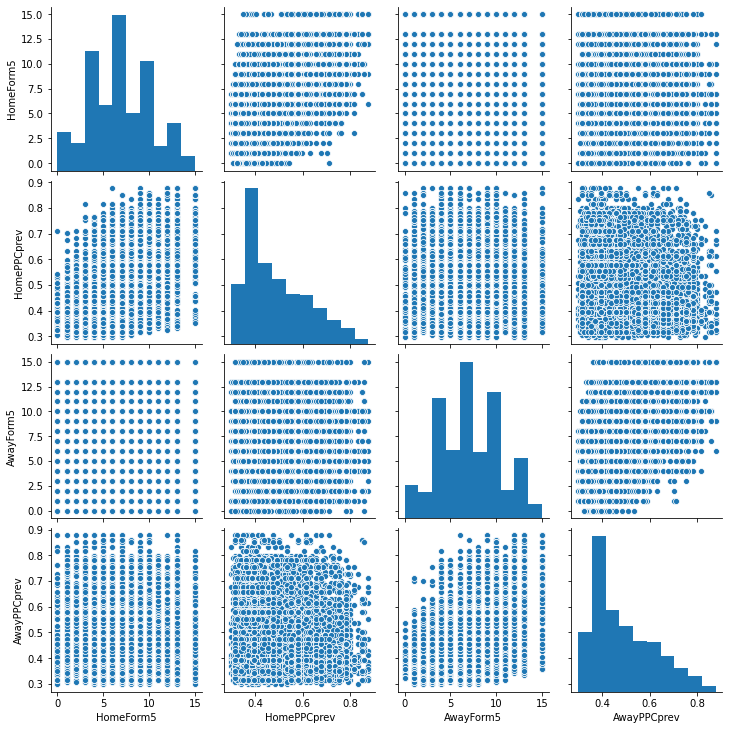

In [72]:
sns.pairplot(EPL[['HomeForm5','HomePPCprev', 'AwayForm5', 'AwayPPCprev']])

In [474]:
# get optimum lambda values for boxcox transformations of home and away PPC previous data
home_lambda = boxcox(EPL['HomePPCprev'].dropna())[1]
away_lambda = boxcox(EPL['AwayPPCprev'].dropna())[1]

In [475]:
# create new columns with boxcox transformed Home/AwayPPCprev data
EPL['HomePPCprev_tf'] = spboxcox(EPL['HomePPCprev'], home_lambda)
EPL['AwayPPCprev_tf'] = spboxcox(EPL['AwayPPCprev'], away_lambda)

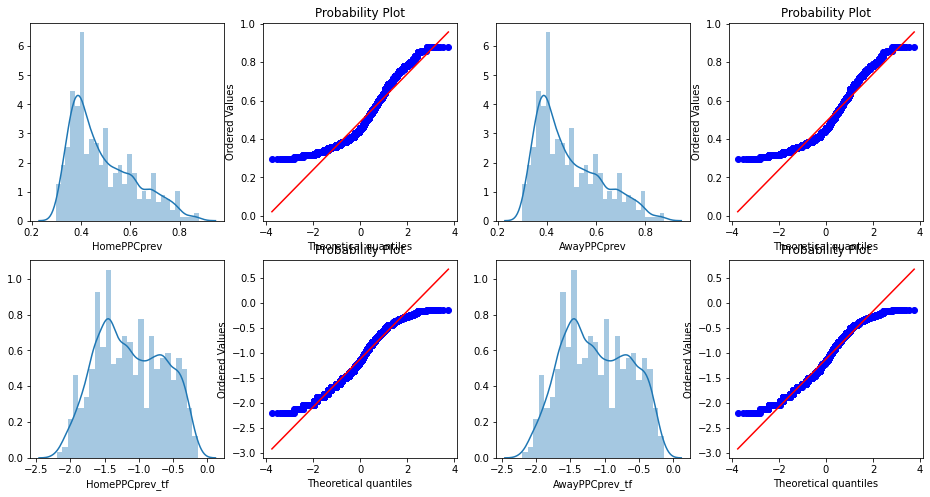

In [447]:
# set up plot size to plot 8 separate plot (2 rows of 4 plots), each of size 4x4
plt.figure(figsize=(16,8))

# plot distribution and QQ-plot for original PPCprev data
ax1 = plt.subplot(241)
plot1 = sns.distplot(EPL['HomePPCprev'])
ax2 = plt.subplot(242)
plot2 = probplot(EPL['HomePPCprev'].dropna(), dist=norm, plot=plt)
ax3 = plt.subplot(243)
plot3 = sns.distplot(EPL['AwayPPCprev'])
ax4 = plt.subplot(244)
plot4 = probplot(EPL['AwayPPCprev'].dropna(), dist=norm, plot=plt)

# plot distribution and QQ-plot for boxcox transformed PPCprev data
ax5 = plt.subplot(245)
plot5 = sns.distplot(EPL['HomePPCprev_tf'])
ax6 = plt.subplot(246)
plot6 = probplot(EPL['HomePPCprev_tf'].dropna(), dist=norm, plot=plt)
ax7 = plt.subplot(247)
plot7 = sns.distplot(EPL['AwayPPCprev_tf'])
ax8 = plt.subplot(248)
plot8 = probplot(EPL['AwayPPCprev_tf'].dropna(), dist=norm, plot=plt)

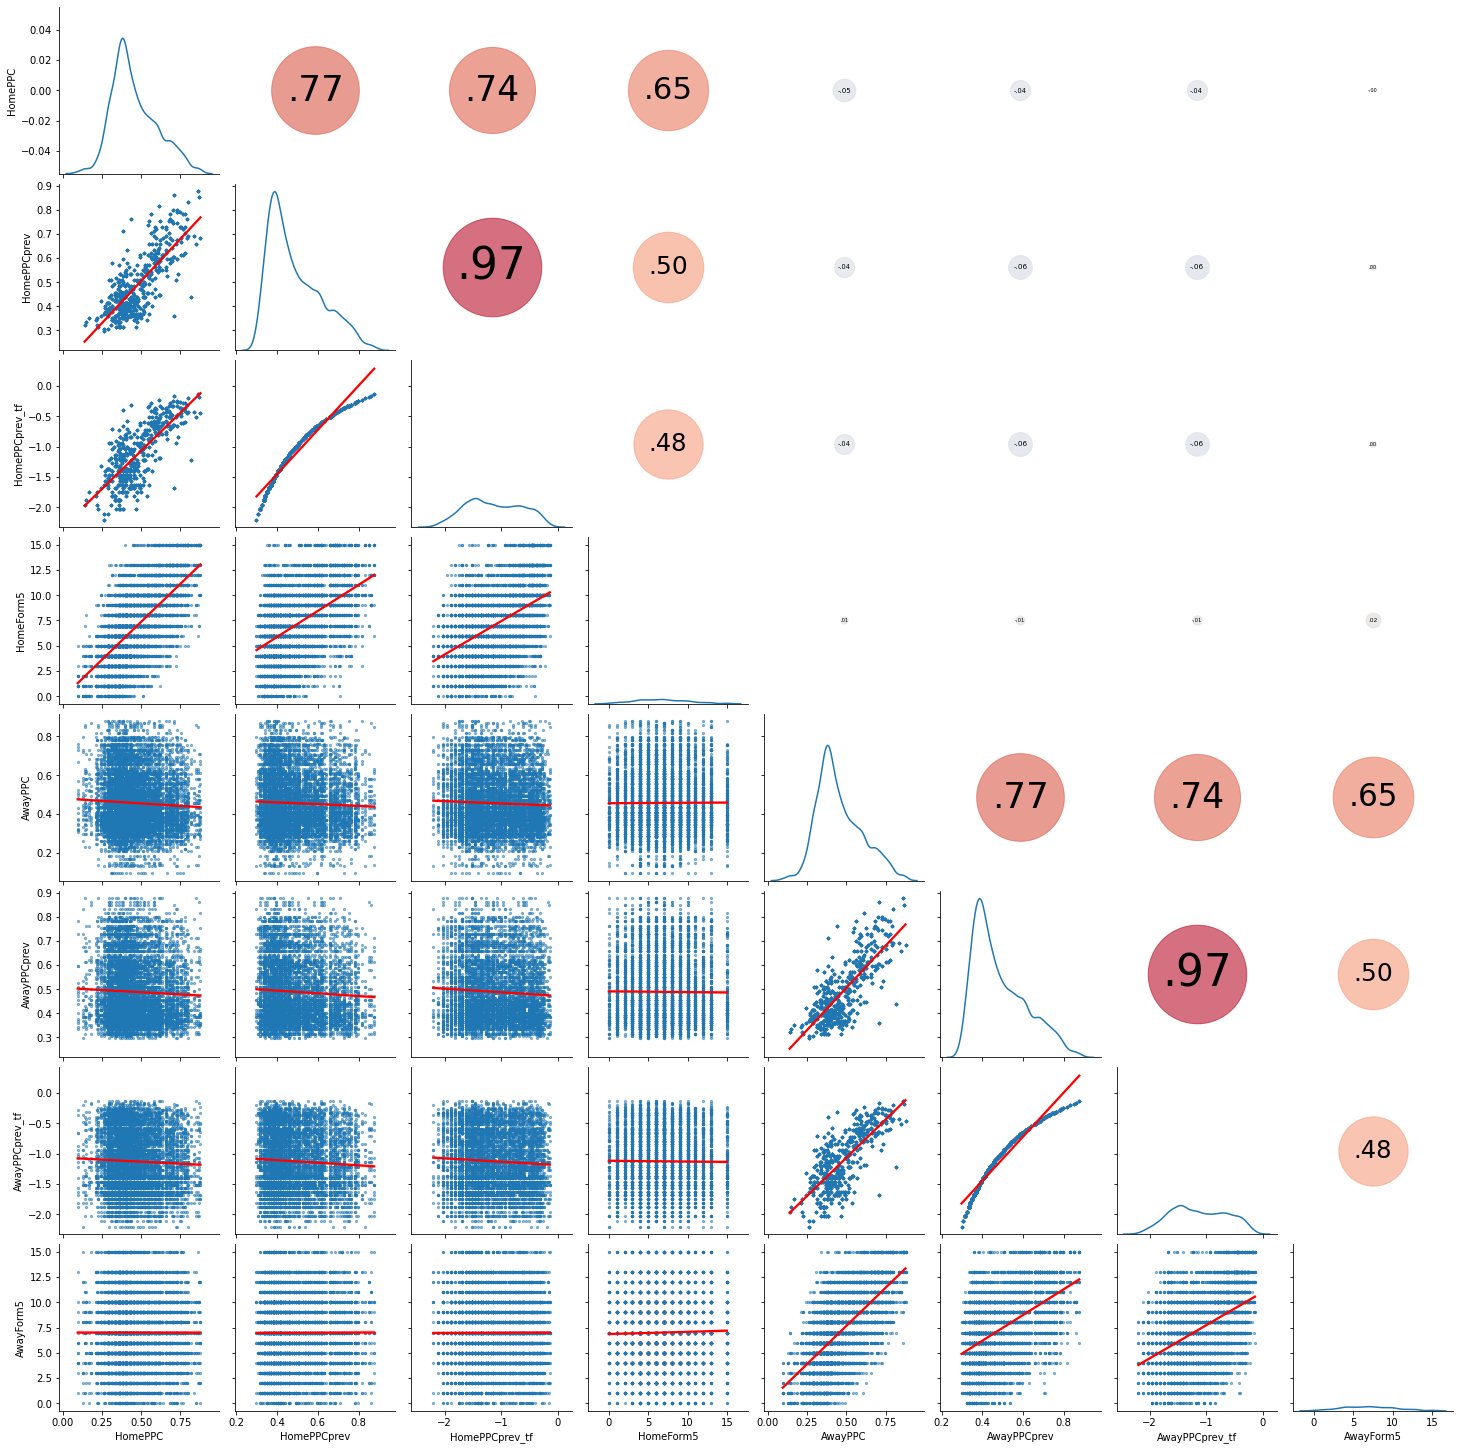

In [76]:
g=sns.PairGrid(EPL[['HomePPC','HomePPCprev','HomePPCprev_tf','HomeForm5','AwayPPC','AwayPPCprev','AwayPPCprev_tf','AwayForm5']])
g=g.map_lower(sns.regplot, scatter_kws={'alpha':0.5, 's':5}, line_kws={'color':'red'})
g=g.map_diag(sns.kdeplot)
g=g.map_upper(corrdot)

Pairs plot showing a subset of the features

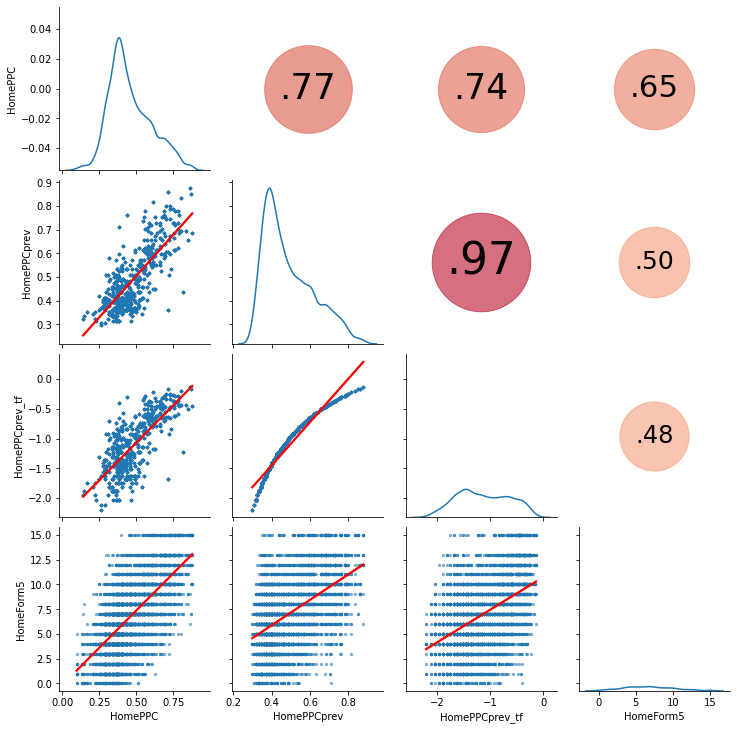

In [77]:
g=sns.PairGrid(EPL[['HomePPC','HomePPCprev','HomePPCprev_tf','HomeForm5']])
g=g.map_lower(sns.regplot, scatter_kws={'alpha':0.5, 's':5}, line_kws={'color':'red'})
g=g.map_diag(sns.kdeplot)
g=g.map_upper(corrdot)

Examples of some regression plots, showing lowess line

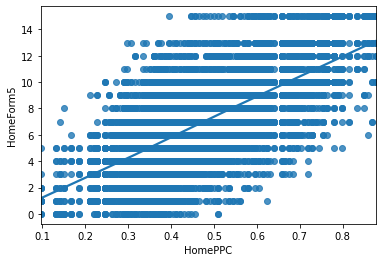

In [257]:
sns.regplot(EPL['HomePPC'], EPL['HomeForm5'], lowess=True)

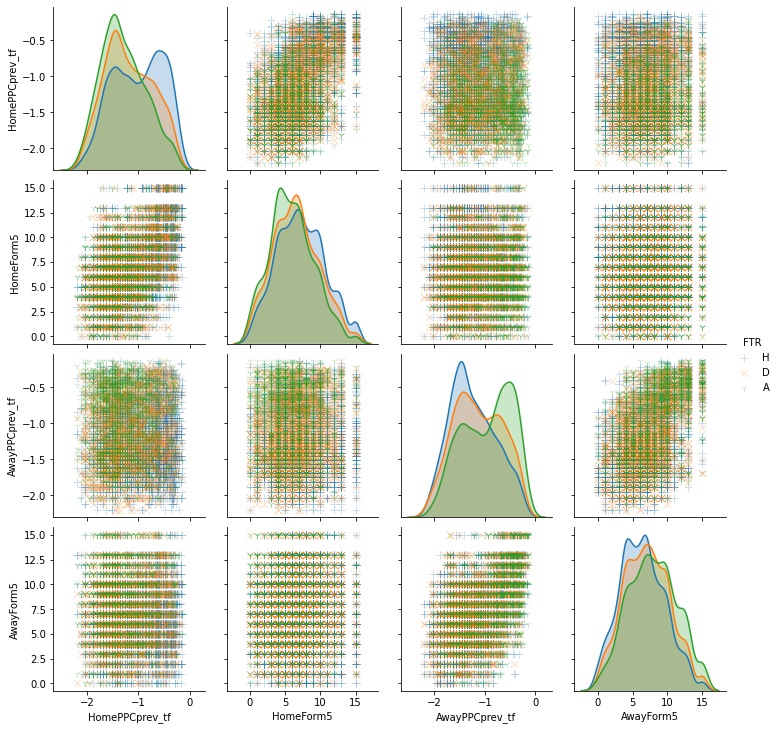

In [79]:
sns.pairplot(EPL[['HomePPCprev_tf','HomeForm5','AwayPPCprev_tf','AwayForm5','FTR']], 
             hue="FTR", plot_kws={'alpha':0.3, 's':50}, markers=['+','x','1'])

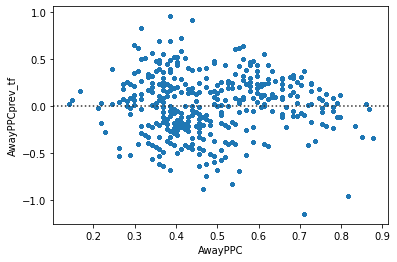

In [80]:
sns.residplot(EPL['AwayPPC'], EPL['AwayPPCprev_tf'],
            scatter_kws={'alpha':0.8, 's':10}, line_kws={'color':'red'})

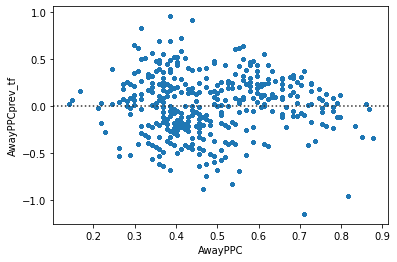

In [81]:
sns.residplot(EPL['AwayPPC'], EPL['AwayPPCprev_tf'],
            scatter_kws={'alpha':0.8, 's':10}, line_kws={'color':'red'}, order=1)

### 6. Impute unavailable values for points in previous season and form

There are several cases where it was not possible to calculate the proportion of points earned by a team in the previous year (i.e. cases where teams are newly promoted, and for all teams in the first available season) and the form value over the past 5 games (i.e. first 5 games for each team each season).

From the correlation dots on the pairs plot above (and as would be expected), we can see that there is a relatively strong correlation between the proportion of points earned by teams in the current season and they're 5 game form value, so it seems reaonable to use the home and away proportion of points earned in the current season to impute the unknown values of 5 game home form and away form respectively. As there are only a finite number of possible form values that a team can have, and they are bounded between 0 and 15, I will use ordinal logistic regression to estimate the probabilities for each unknown form value of being each of the possible 15 values, and I will randomly sample from these probabilities as an estimate of the unknown form value (rather than choosing most probable value, to preserve variance in the data).

Likewise, there is a similarly strong correlation between the proportion of points earned by teams in the current season and the proportion of points they earned in the previous season. We can use this relationship to impute values for the unknown proportion of points earned in the previous year values using simple linear regression.

In [448]:
print(EPL['HomePPC'].corr(EPL['HomeForm5']))
print(EPL['AwayPPC'].corr(EPL['AwayForm5']))

0.6454406984758209
0.6505244996144792


In [449]:
print(EPL['HomePPC'].corr(EPL['HomePPCprev_tf']))
print(EPL['AwayPPC'].corr(EPL['AwayPPCprev_tf']))

0.7416225709613654
0.7416225723584337


#### 6.1 Imputing unavailable form values

We will use the proportion of points earned by teams in the current season to impute their form values in cases where the form values couldn't be calculated. First we can effectively create training and test sets for the data, where training sets include HomePPC/AwayPPC and HomeForm5/AwayForm5 values for all cases where the HomeForm5/AwayForm5 values are available, and test sets include the HomePPC/AwayPPC values for the remaining cases where HomeForm5/AwayForm5 values are not available.

After training separate models for the home and away data, the predicted probabilities of belonging to each 'class' (i.e. 0,1,..,12,13,15) for each item in the test data is calculated, and the final estimated value in each case is obtained by randomly sampling the class value based on the associated class probabilities.

In [476]:
# split home form and PPC data into train and test (test will be all NaN values in HomeForm5 column)
home_x_test = EPL.loc[EPL.loc[:,'HomeForm5'].isna(),['HomePPC']]
home_x_train = EPL.loc[EPL.loc[:,'HomeForm5'].notna(),['HomePPC']]
home_y_train = (EPL.loc[EPL.loc[:,'HomeForm5'].notna(),['HomeForm5']]).values.squeeze()

# split away form and PPC data into train and test (test will be all NaN values in AwayForm5 column)
away_x_test = EPL.loc[EPL.loc[:,'AwayForm5'].isna(),['AwayPPC']]
away_x_train = EPL.loc[EPL.loc[:,'AwayForm5'].notna(),['AwayPPC']]
away_y_train = (EPL.loc[EPL.loc[:,'AwayForm5'].notna(),['AwayForm5']]).values.squeeze()

In [477]:
# encode y_train data to only include values from 0 to n categories
home_le = LabelEncoder()
home_le.fit(np.array(home_y_train))
home_y_train2 = home_le.transform(np.array(home_y_train))

away_le = LabelEncoder()
away_le.fit(np.array(away_y_train))
away_y_train2 = home_le.transform(np.array(away_y_train))

In [478]:
# fit training data to ordinal logistic regression model (home form data)
ord_reg_home = mord.LogisticAT()
ord_reg_home.fit(np.array(home_x_train), np.array(home_y_train2))
# generate class probabilities for the test data from the model
home_y_predprobs = ord_reg_home.predict_proba(home_x_test)

# fit training data to ordinal logistic regression model (away form data)
ord_reg_away = mord.LogisticAT()
ord_reg_away.fit(np.array(away_x_train), np.array(away_y_train2))
# generate class probabilities for the test data from the model
away_y_predprobs = ord_reg_away.predict_proba(away_x_test)

In [479]:
# create list of possible form values (integers from 0 to 15 but with 14 omitted)
classlist = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,15]

# create 1d arrays of zeros to store estimated form values
home_y_pred = np.zeros(home_y_predprobs.shape[0])
away_y_pred = np.zeros(away_y_predprobs.shape[0])

# set seed
np.random.seed(20203868)

# loop through all rows of the predicted probabilities array 
for i in range(home_y_predprobs.shape[0]):
    # get list of class probabilities for the current form value
    problist = home_y_predprobs[i,:]
    # sample the form value based on the probabilities, add to array of predicted values
    home_y_pred[i] = np.random.choice(classlist, 1, p=problist)
    
# loop through all rows of the predicted probabilities array 
for i in range(away_y_predprobs.shape[0]):
    # get list of class probabilities for the current form value
    problist = away_y_predprobs[i,:]
    # sample the form value based on the probabilities, add to array of predicted values
    away_y_pred[i] = np.random.choice(classlist, 1, p=problist)

In [480]:
print('Home Training Data:\nMean = %.2f, Variance = %.2f' %(np.mean(home_y_train), np.var(home_y_train)))
print('\nHome Test Data:\nMean = %.2f, Variance = %.2f' %(np.mean(home_y_pred), np.var(home_y_pred)))

Home Training Data:
Mean = 6.73, Variance = 11.21

Home Test Data:
Mean = 6.82, Variance = 11.76


In [481]:
print('Away Training Data:\nMean = %.2f, Variance = %.2f' %(np.mean(away_y_train), np.var(away_y_train)))
print('\nAway Test Data:\nMean = %.2f, Variance = %.2f' %(np.mean(away_y_pred), np.var(away_y_pred)))

Away Training Data:
Mean = 7.00, Variance = 11.13

Away Test Data:
Mean = 6.86, Variance = 10.79


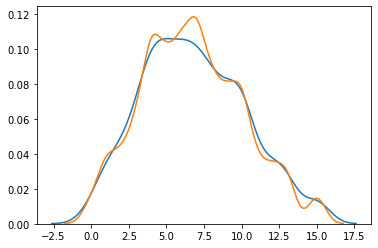

In [482]:
sns.kdeplot(home_y_pred)
sns.kdeplot(home_y_train)

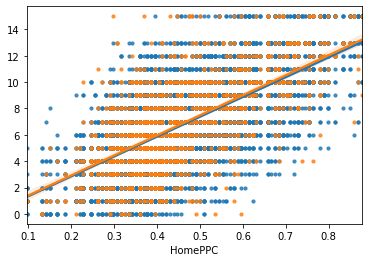

In [483]:
sns.regplot(home_x_train, home_y_train, scatter_kws={'alpha':0.8, 's':10})
sns.regplot(home_x_test, home_y_pred, scatter_kws={'alpha':0.8, 's':10})

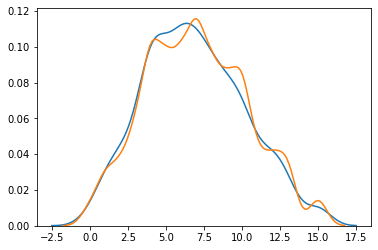

In [484]:
sns.kdeplot(away_y_pred)
sns.kdeplot(away_y_train)

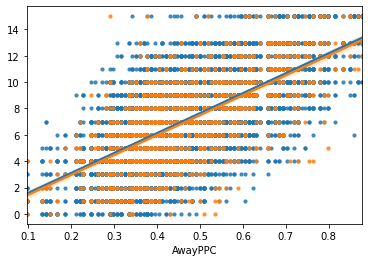

In [485]:
sns.regplot(away_x_train, away_y_train, scatter_kws={'alpha':0.8, 's':10})
sns.regplot(away_x_test, away_y_pred, scatter_kws={'alpha':0.8, 's':10})

In [486]:
EPL.loc[EPL.loc[:,'HomeForm5'].isna(),['HomeForm5']] = home_y_pred
EPL.loc[EPL.loc[:,'AwayForm5'].isna(),['AwayForm5']] = away_y_pred

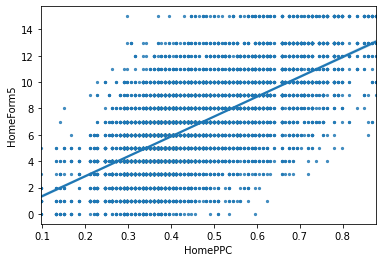

In [487]:
sns.regplot(EPL['HomePPC'], EPL['HomeForm5'], scatter_kws={'s':5})

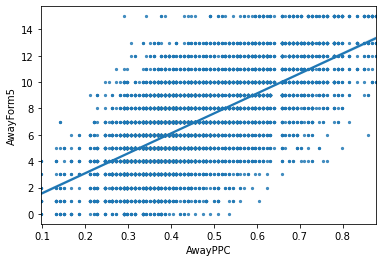

In [488]:
sns.regplot(EPL['AwayPPC'], EPL['AwayForm5'], scatter_kws={'s':5})

#### 6.2 Imputing unavailable Home/AwayPPCprev values

We will use the proportion of points earned by teams in the current season to impute the proportion of points they earned in the previous season in cases where these values couldn't be calculated. First we can effectively create training and test sets for the data. As  training sets include HomePPC and HomePPCprev_tf values for all cases where the HomePPCprev_tf values are available...

In [489]:
# split home form and PPC data into train and test (test will be all NaN values in HomePPCprev_tf column)
homep_x_test = EPL.loc[EPL.loc[:,'HomePPCprev_tf'].isna(),['HomePPC']]
homep_x_train = EPL.loc[EPL.loc[:,'HomePPCprev_tf'].notna(),['HomePPC']]
homep_y_train = EPL.loc[EPL.loc[:,'HomePPCprev_tf'].notna(),['HomePPCprev_tf']]

# split away form and PPC data into train and test (test will be all NaN values in AwayPPCprev_tf column)
awayp_x_test = EPL.loc[EPL.loc[:,'AwayPPCprev_tf'].isna(),['AwayPPC']]
awayp_x_train = EPL.loc[EPL.loc[:,'AwayPPCprev_tf'].notna(),['AwayPPC']]
awayp_y_train = EPL.loc[EPL.loc[:,'AwayPPCprev_tf'].notna(),['AwayPPCprev_tf']]

In [490]:
# fit linear regression model to home training data, predict values for the missing HomePPCprev values
regr_homep = linear_model.LinearRegression()
regr_homep.fit(homep_x_train, homep_y_train)
homep_y_pred = regr_homep.predict(homep_x_test)

# fit linear regression model to away training data, predict values for the missing AwayPPCprev values
regr_awayp = linear_model.LinearRegression()
regr_awayp.fit(awayp_x_train, awayp_y_train)
awayp_y_pred = regr_awayp.predict(awayp_x_test)

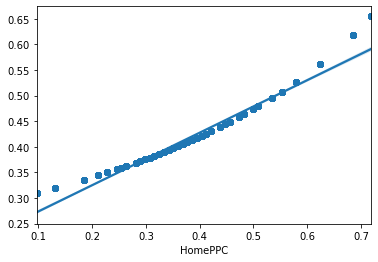

In [491]:
#sns.regplot(homep_x_test, homep_y_pred)
sns.regplot(homep_x_test, inv_boxcox(homep_y_pred, home_lambda))

In [492]:
# calculate standard error for known home PPCprev values (after logit transformation)
home_stderror = logit_tf(inv_boxcox(homep_y_train, home_lambda)).std()

# get data frame containing list of teams in each season with no PPCprev values
NoPPCprev = (EPL.loc[(EPL.loc[:,'HomePPCprev_tf'].isna()), ['Season', 'HomeTeam']]).drop_duplicates()

# set seed
np.random.seed(20203868)

# get random normal samples to add to predicted home/away PPC prev values 
# (with home PPCprev strandard error)
PPCprev_rand = np.random.normal(size = len(NoPPCprev), loc = 0, scale = home_stderror)
NoPPCprev['rand'] = PPCprev_rand

In [493]:
# get dataframe of all fixtures where home team has no PPCprev value
homep_NoPPCprev = EPL.loc[EPL.loc[:,'HomePPCprev_tf'].isna(),['Season', 'HomeTeam']]
# add predicted values for home teams' PPC prev after boxcox and logit transorming the data
homep_NoPPCprev['Pred'] = logit_tf(inv_boxcox(homep_y_pred, home_lambda))
# add column to store random values
homep_NoPPCprev['Rand'] = 0.0
# reset row indices
homep_NoPPCprev.reset_index(drop=True, inplace=True)

# loop through each fixture in the data frame
for game in range(homep_NoPPCprev.shape[0]):
    # get random normal value for the current home team/current season
    hometeam_rand = NoPPCprev[(NoPPCprev['HomeTeam']==homep_NoPPCprev.iloc[game,]['HomeTeam']) &
    (NoPPCprev['Season']==homep_NoPPCprev.iloc[game,]['Season'])]['rand'].astype(float)
    # add random value to the Rand column
    homep_NoPPCprev.at[game,'Rand'] = hometeam_rand

# add random normal noise to predicted values and perform logisitc transform
homep_NoPPCprev['PredRand'] = logistic_tf(homep_NoPPCprev['Pred'] + homep_NoPPCprev['Rand'])

In [494]:
# get dataframe of all fixtures where away team has no PPCprev value
awayp_NoPPCprev = EPL.loc[EPL.loc[:,'AwayPPCprev_tf'].isna(),['Season', 'AwayTeam']]
# add predicted values for away teams' PPC prev
awayp_NoPPCprev['Pred'] = logit_tf(inv_boxcox(awayp_y_pred, home_lambda))
# add column to store random values
awayp_NoPPCprev['Rand'] = 0.0
# reset row indices
awayp_NoPPCprev.reset_index(drop=True, inplace=True)

# loop through each fixture in the data frame
for game in range(awayp_NoPPCprev.shape[0]):
    # get random normal value for the current away team/current season
    awayteam_rand = NoPPCprev[(NoPPCprev['HomeTeam']==awayp_NoPPCprev.iloc[game,]['AwayTeam']) &
    (NoPPCprev['Season']==awayp_NoPPCprev.iloc[game,]['Season'])]['rand'].astype(float)
    # add random value to the Rand column
    awayp_NoPPCprev.at[game,'Rand'] = awayteam_rand

# add random normal noise to predicted values and perform logisitc transform
awayp_NoPPCprev['PredRand'] = logistic_tf(awayp_NoPPCprev['Pred'] + awayp_NoPPCprev['Rand'])

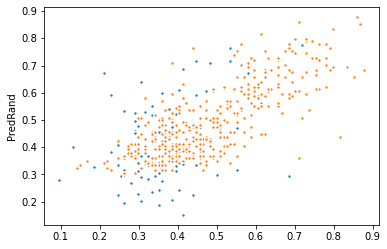

In [501]:
sns.scatterplot(np.array(awayp_x_test).squeeze(), awayp_NoPPCprev['PredRand'], s=10)
sns.scatterplot(np.array(awayp_x_train).squeeze(), np.array(inv_boxcox(awayp_y_train, away_lambda)).squeeze(), s=10)

In [496]:
# add values to the EPL data frame
EPL.loc[EPL.loc[:,'HomePPCprev_tf'].isna(),['HomePPCprev_tf']] = boxcox(homep_NoPPCprev['PredRand'].values, home_lambda)
EPL.loc[EPL.loc[:,'AwayPPCprev_tf'].isna(),['AwayPPCprev_tf']] = boxcox(awayp_NoPPCprev['PredRand'].values, away_lambda)

# add transformed values to the EPL data frame
# (inverse of boxcox transformations performed earlier)
EPL.loc[EPL.loc[:,'HomePPCprev'].isna(),['HomePPCprev']] = homep_NoPPCprev['PredRand'].values
EPL.loc[EPL.loc[:,'AwayPPCprev'].isna(),['AwayPPCprev']] = awayp_NoPPCprev['PredRand'].values

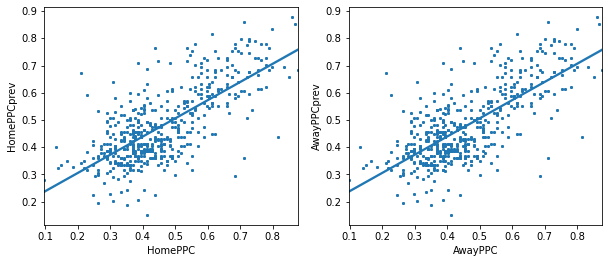

In [497]:
# set up plot size
plt.figure(figsize=(10,4))

ax1 = plt.subplot(121)
plot1 = sns.regplot(EPL['HomePPC'], EPL['HomePPCprev'], scatter_kws={'s':1})
ax2 = plt.subplot(122)
plot2 = sns.regplot(EPL['AwayPPC'], EPL['AwayPPCprev'], scatter_kws={'s':1})

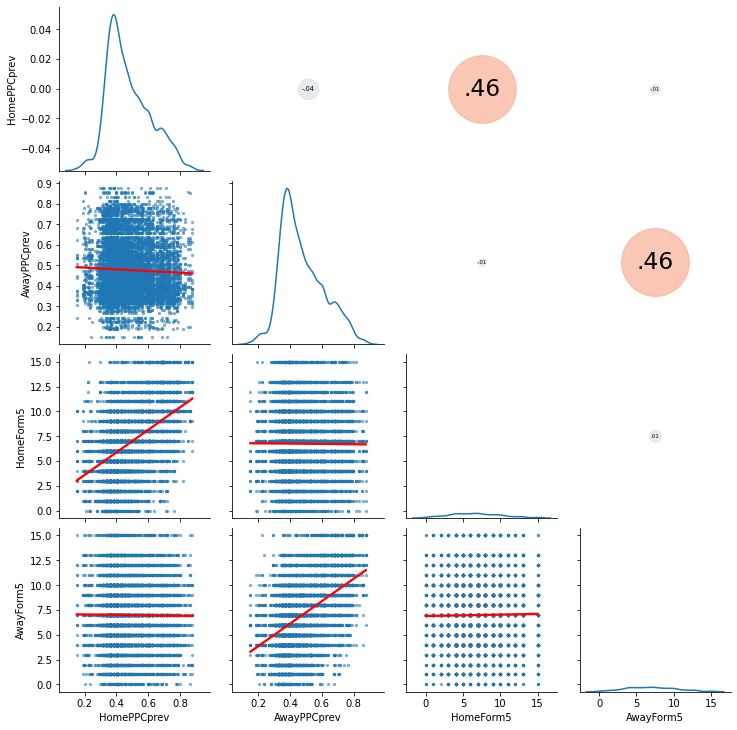

In [512]:
g=sns.PairGrid(EPL[['HomePPCprev', 'AwayPPCprev', 'HomeForm5', 'AwayForm5', 'FTR']])
g=g.map_lower(sns.regplot, scatter_kws={'alpha':0.5, 's':5}, line_kws={'color':'red'})
g=g.map_diag(sns.kdeplot)
g=g.map_upper(corrdot)

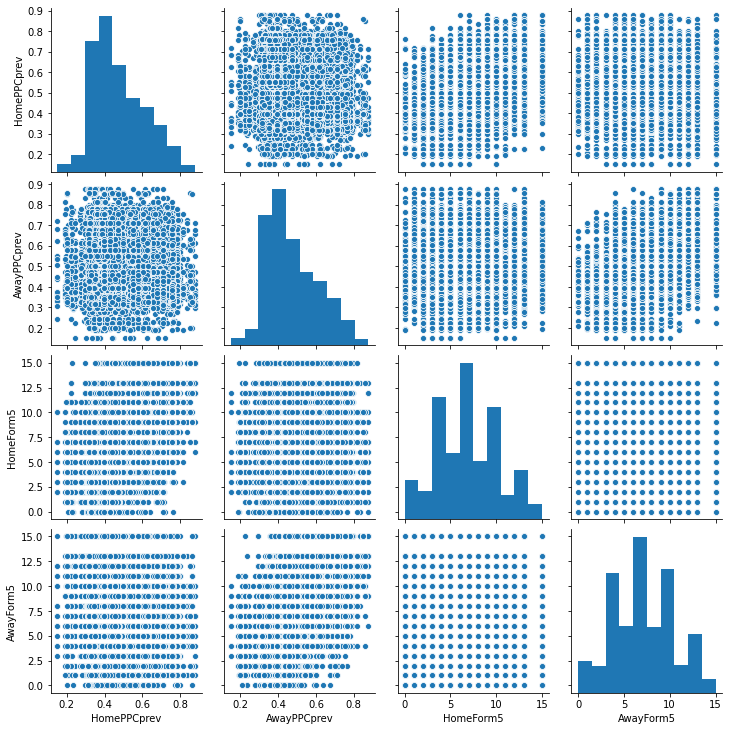

In [516]:
sns.pairplot(EPL[['HomePPCprev', 'AwayPPCprev', 'HomeForm5', 'AwayForm5', 'FTR']])

### 11. LDA

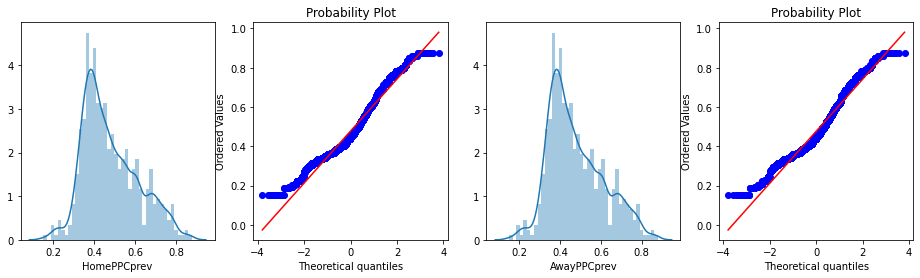

In [540]:
# set up plot size
plt.figure(figsize=(16,4))

# plot distribution and QQ-plot for PPCprev data
ax1 = plt.subplot(141)
plot1 = sns.distplot(EPL['HomePPCprev'])
ax2 = plt.subplot(142)
plot2 = probplot(EPL['HomePPCprev'], dist=norm, plot=plt)
ax3 = plt.subplot(143)
plot3 = sns.distplot(EPL['AwayPPCprev'])
ax4 = plt.subplot(144)
plot4 = probplot(EPL['AwayPPCprev'], dist=norm, plot=plt)

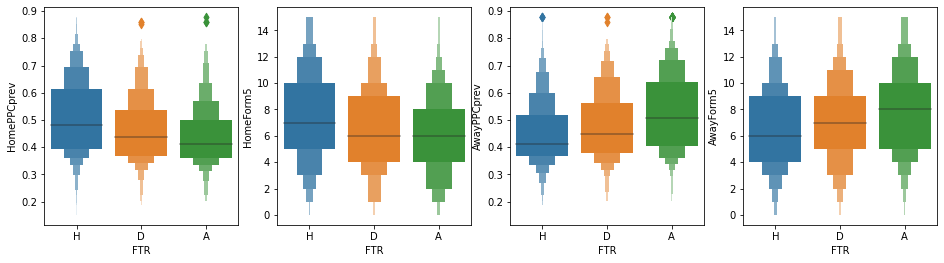

In [541]:
# set up plot size
plt.figure(figsize=(16,4))

ax1 = plt.subplot(141)
plot1=sns.boxenplot(EPL['FTR'], EPL['HomePPCprev'])
ax2 = plt.subplot(142)
plot2=sns.boxenplot(EPL['FTR'], EPL['HomeForm5'])
ax3 = plt.subplot(143)
plot3=sns.boxenplot(EPL['FTR'], EPL['AwayPPCprev'])
ax4 = plt.subplot(144)
plot4=sns.boxenplot(EPL['FTR'], EPL['AwayForm5'])

In [687]:
#xtrain1 = EPL[['HomePPCprev', 'AwayPPCprev', 'HomeForm5', 'AwayForm5']]
xtrain1 = EPL[['HomePPCprev', 'AwayPPCprev']]
ytrain1 = EPL['FTR'].values

In [688]:
lda_mod = lda()
lda_mod.fit(xtrain1, ytrain1)
preds_lda = lda_mod.predict(xtrain1)
probs_lda = lda_mod.predict_proba(xtrain1)

In [689]:
metrics.confusion_matrix(ytrain1, preds_lda)

array([[1084,    2, 1564],
       [ 595,    3, 1835],
       [ 671,    0, 3746]])

In [558]:
Counter(ytrain1)

Counter({'H': 4417, 'D': 2433, 'A': 2650})

In [559]:
Counter(preds_lda)

Counter({'A': 2225, 'H': 7275})

In [560]:
probs_lda

array([[0.74628809, 0.15529249, 0.09841941],
       [0.15117797, 0.23507181, 0.61375023],
       [0.5640247 , 0.23765555, 0.19831975],
       ...,
       [0.83583936, 0.11399045, 0.05017018],
       [0.46891754, 0.26064089, 0.27044156],
       [0.22291351, 0.27261759, 0.50446891]])

In [561]:
2694/9500

0.28357894736842104

In [562]:
2375/9500

0.25

In [563]:
4431/9500

0.46642105263157896

In [690]:
probs_lda.sum(axis=0)/9500

array([0.27895629, 0.25642192, 0.46462179])

In [581]:
lda_mod.classes_

array(['A', 'D', 'H'], dtype=object)

In [718]:
testfixtures = EPL[EPL['Season']==24][['HomePPC', 'AwayPPC']].reset_index(drop=True)

test_preds = lda_mod.predict_proba(testfixtures)
testfixtures['FTRpreds'] = ''

for i in range(test_preds.shape[0]):
    testfixtures['FTRpreds'].iloc[i] = random.choices(lda_mod.classes_, test_preds[i,:], k=1)[0]
    
testfixtures['HomeTeam'] = EPL[EPL['Season']==24]['HomeTeam'].reset_index(drop=True)
testfixtures['AwayTeam'] = EPL[EPL['Season']==24]['AwayTeam'].reset_index(drop=True)

/Users/fanahanmcsweeney/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [729]:
for i in range(test_preds.shape[0]):
    testfixtures['FTRpreds'].iloc[i] = random.choices(lda_mod.classes_, test_preds[i,:], k=1)[0]
    
# get list of unique teams in the current season
teams = sorted(list(set(testfixtures['AwayTeam'])))

# create dataframe with relevant columns, add teams as the 1st column
WLD_cols = ['W','D','L','PointsTot','PointsPC']
teams_WLD1 = DataFrame(columns=WLD_cols)
teams_WLD1.insert(0,"Team",teams)
    
## create data frame to store points in each game
teams_ppg = DataFrame(columns=range(1,39))
teams_ppg.insert(0,"Team",teams)
## create data frame to store 5 game form
teams_form = DataFrame(columns=range(1,39))
teams_form.insert(0,"Team",teams)
    
# loop through all teams in the current season
for team in teams:
    # count total no. of wins/losses/draws for each team in the current season
    Ws = sum(((testfixtures["HomeTeam"]==team) & (testfixtures["FTRpreds"]=='H')) | ((testfixtures["AwayTeam"]==team) & (testfixtures["FTRpreds"]=='A')))
    Ds = sum(((testfixtures["HomeTeam"]==team) | (testfixtures["AwayTeam"]==team)) & (testfixtures["FTRpreds"]=='D'))
    Ls = sum(((testfixtures["HomeTeam"]==team) & (testfixtures["FTRpreds"]=='A')) | ((testfixtures["AwayTeam"]==team) & (testfixtures["FTRpreds"]=='H')))
    # count total number of points and % of overall points for each team
    Points = 3*Ws + 1*Ds
    PointsPC = Points / (38*3)
    # add season stats for current team to the dataframe
    teams_WLD1.loc[teams_WLD['Team']==team, WLD_cols] = [Ws, Ds, Ls, Points, PointsPC]
        
# sort by highest points
teams_WLD1 = teams_WLD1.sort_values('Team')

/Users/fanahanmcsweeney/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [730]:
teams_WLD1

,Team,W,D,L,PointsTot,PointsPC
0,Arsenal,16,6,16,54,0.473684
1,Aston Villa,14,4,20,46,0.403509
2,Bournemouth,9,11,18,38,0.333333
3,Brighton,11,10,17,43,0.377193
4,Burnley,15,7,16,52,0.45614
5,Chelsea,16,14,8,62,0.54386
6,Crystal Palace,9,10,19,37,0.324561
7,Everton,12,12,14,48,0.421053
8,Leicester,20,10,8,70,0.614035
9,Liverpool,28,5,5,89,0.780702


In [728]:
all_seasons_WLD[all_seasons_WLD['Season']==24].sort_values('Team')

,Season,Team,W,D,L,PointsTot,PointsPC
0,24,Arsenal,14,14,10,56,0.491228
1,24,Aston Villa,9,8,21,35,0.307018
2,24,Bournemouth,9,7,22,34,0.298246
3,24,Brighton,9,14,15,41,0.359649
4,24,Burnley,15,9,14,54,0.473684
5,24,Chelsea,20,6,12,66,0.578947
6,24,Crystal Palace,11,10,17,43,0.377193
7,24,Everton,13,10,15,49,0.429825
8,24,Leicester,18,8,12,62,0.54386
9,24,Liverpool,32,3,3,99,0.868421


### 12. Random forest

In [482]:
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
ytrain1 = np.array([number[0] for number in lb.fit_transform(ytrain1)])

In [485]:
for md in range(5,20):
    regr = rf(max_depth=md, random_state=0)
    #regr.fit(xtrain1, ytrain1)
    print(md,"-",np.mean(cross_val_score(regr, xtrain1, ytrain1, cv=5, scoring='precision')))

/Users/fanahanmcsweeney/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fanahanmcsweeney/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4 - 0.2625
5 - 0.5075396825396826
6 - 0.48731803327391565
7 - 0.47754161043634724
8 - 0.4375203181237664
9 - 0.44698635976129586
10 - 0.41290328869442794
11 - 0.40093649796565217
12 - 0.3980815674529005
13 - 0.3948663747296941
14 - 0.36064566138474724
15 - 0.36642255180294264
16 - 0.35128191762870503
17 - 0.3516653951158233
18 - 0.3400345448580253
19 - 0.32905399933366747


In [469]:
regr = rf(max_depth=5, random_state=0)
regr.fit(xtrain1, ytrain1)
preds_rf = regr.predict(xtrain1)

In [470]:
Counter(preds_rf)

Counter({'A': 1302, 'H': 8198})

In [457]:
metrics.confusion_matrix(ytrain1, preds_rf)

array([[2182,   40,  472],
       [  66, 1840,  469],
       [  44,   13, 4374]])

In [458]:
probs_rf.sum(axis=0)/9500

array([0.28423062, 0.25091105, 0.46485832])

In [459]:
regr.classes_

array(['A', 'D', 'H'], dtype=object)